In [2]:
!nvidia-smi

!pip install pandas numpy scikit-learn matplotlib seaborn tqdm
!pip install statsmodels
!pip install torch --index-url https://download.pytorch.org/whl/cu118

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


/bin/bash: line 1: nvidia-smi: command not found
Looking in indexes: https://download.pytorch.org/whl/cu118


This pipeline ingests a raw F1 CSV, normalizes columns and infers the primary lap time, cleans pit/out laps and extreme outliers, segments the data into unique stints by detecting compound/age resets, applies a per-stint linear fuel correction to create lap_time_fuelcorr, and derives the final degradation_target relative to the first stint lap, outputting a clean DataFrame and printing the raw-to-clean shape.

In [4]:
import pandas as pd
import numpy as np

CSV_PATH = "/content/new_tyre_degradation_processed.csv"
df = pd.read_csv(CSV_PATH)

df.columns = [c.lower().strip() for c in df.columns]

df["date_start"] = pd.to_datetime(df["date_start"], errors="coerce")

# Lap time column unify
df["lap_time_s"] = pd.to_numeric(df["lap_duration"], errors="coerce")

df = df.sort_values(["driver_number", "date_start"]).reset_index(drop=True)

# Gap between laps
df["lap_time_gap"] = df.groupby("driver_number")["date_start"].diff().dt.total_seconds()

# Detect lap number reset -> common after pit
df["lapnum_shift"] = df.groupby("driver_number")["lap_number"].shift(1)
df["lapnum_reset"] = (df["lap_number"] < df["lapnum_shift"]).astype(int)

# Detect compound change
df["compound_shift"] = df.groupby("driver_number")["compound"].shift(1)
df["compound_change"] = (df["compound"] != df["compound_shift"]).astype(int)

# Stint break logic
df["new_stint_flag"] = (
    (df["compound_change"] == 1) |
    (df["lapnum_reset"] == 1) |
    (df["lap_time_gap"] > 30)   # 30 sec threshold for pit window
).astype(int).fillna(1)

df["stint_id"] = df.groupby("driver_number")["new_stint_flag"].cumsum()

# Recompute tyre age based on stint lap index (correct)
df["stint_lap_index"] = df.groupby(["driver_number","stint_id"]).cumcount() + 1
df["tyre_age_recalc"] = df["stint_lap_index"].astype(float)

# Fuel correction
def fuel_correct(g):
    x = g["stint_lap_index"].values.astype(float)
    y = g["lap_time_s"].values.astype(float)
    if len(x) < 3:
        g["lap_time_fuelcorr"] = y
        g["fuel_slope_s_per_lap"] = 0.0
        return g
    X = np.c_[np.ones(len(x)), x]
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    slope = beta[1]
    g["lap_time_fuelcorr"] = y - slope * x
    g["fuel_slope_s_per_lap"] = slope
    return g

df = df.groupby(["driver_number","stint_id"], group_keys=False).apply(fuel_correct)

df["stint_start_time"] = df.groupby(["driver_number","stint_id"])["lap_time_fuelcorr"].transform("first")
df["degradation_target"] = df["lap_time_fuelcorr"] - df["stint_start_time"]

df_clean = df[
    [
        "date_start","driver_number","compound",
        "stint_id","stint_lap_index","tyre_age_recalc",
        "lap_time_s","lap_time_fuelcorr",
        "fuel_slope_s_per_lap","degradation_target"
    ]
].copy()

df_clean.reset_index(drop=True, inplace=True)

print("Total stints detected:", df_clean["stint_id"].nunique())
df_clean.head()


/tmp/ipython-input-855053948.py:5: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


Total stints detected: 3056


/tmp/ipython-input-855053948.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["driver_number","stint_id"], group_keys=False).apply(fuel_correct)


,date_start,driver_number,compound,stint_id,stint_lap_index,tyre_age_recalc,lap_time_s,lap_time_fuelcorr,fuel_slope_s_per_lap,degradation_target
0,2023-02-23 07:02:29.454000+00:00,1.0,MEDIUM,1.0,1.0,1.0,97.780,97.780,0.0,0.0
1,2023-02-23 07:04:07.140000+00:00,1.0,MEDIUM,2.0,1.0,1.0,106.980,106.980,0.0,0.0
2,2023-02-23 07:32:26.230000+00:00,1.0,MEDIUM,3.0,1.0,1.0,95.655,95.655,0.0,0.0
3,2023-02-23 07:34:01.729000+00:00,1.0,MEDIUM,4.0,1.0,1.0,156.234,156.234,0.0,0.0
4,2023-02-23 07:36:38.039000+00:00,1.0,MEDIUM,5.0,1.0,1.0,147.700,147.700,0.0,0.0


In [10]:
from scipy.optimize import curve_fit
import statsmodels.api as sm
from tqdm import tqdm
import numpy as np
import pandas as pd

def model_exp(x, A, lam):
    return A * (1 - np.exp(-lam * x))

def model_poly(x, a, b):
    return a * x + b * (x ** 2)

def model_log(x, g):
    return g * np.log(1 + x)

stint_params = []
residual_rows = []

# Only use stints with >= 6 laps
usable = df_clean.groupby("stint_id").filter(lambda g: len(g) >= 6)

for sid, g in tqdm(usable.groupby("stint_id")):
    x = g["stint_lap_index"].values.astype(float)
    y = g["degradation_target"].values.astype(float)

    results = []

    # Try Exponential
    try:
        popt_e, _ = curve_fit(model_exp, x, y, maxfev=5000)
        y_pred_e = model_exp(x, *popt_e)
        aic_e = sm.OLS(y, y_pred_e).fit().aic
        results.append(("exp", popt_e, y_pred_e, aic_e))
    except:
        pass

    # Try Polynomial
    try:
        popt_p, _ = curve_fit(model_poly, x, y, maxfev=5000)
        y_pred_p = model_poly(x, *popt_p)
        aic_p = sm.OLS(y, y_pred_p).fit().aic
        results.append(("poly", popt_p, y_pred_p, aic_p))
    except:
        pass

    # Try Logarithmic
    try:
        popt_l, _ = curve_fit(model_log, x, y, maxfev=5000)
        y_pred_l = model_log(x, *popt_l)
        aic_l = sm.OLS(y, y_pred_l).fit().aic
        results.append(("log", popt_l, y_pred_l, aic_l))
    except:
        pass

    if not results:
        continue

    # Select best (lowest AIC)
    form, params, y_pred, aic = min(results, key=lambda r: r[3])

    stint_params.append([sid, form] + list(params))

    g_res = g.copy()
    g_res["parametric_pred"] = y_pred
    g_res["residual"] = y - y_pred
    residual_rows.append(g_res)

stint_param_df = pd.DataFrame(stint_params, columns=["stint_id","model_form","p1","p2"])
residual_df = pd.concat(residual_rows).reset_index(drop=True)

print("Usable stints:", residual_df["stint_id"].nunique())
residual_df.head()


Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-209995998.py:48: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_l, _ = curve_fit(model_log, x, y, maxfev=5000)
/usr/local/lib/python3.12/dist-packages/statsmodels/tools/tools.py:271: RuntimeWarning: overflow encountered in scalar divide
  s[i] = 1./s[i]
/tmp/ipython-input-209995998.py:30: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_e, _ = curve_fit(model_exp, x, y, maxfev=5000)
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/tmp/ipython-input-209995998.py:48: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_l, _ = curve_fit(model_log, x, y, maxfev=5000)
/usr/local/lib/python3.12/dist-packages/statsmodels/tools/tools.py:271: RuntimeWarning: overflow encountered in scalar divide
  s

Usable stints: 2945


,date_start,driver_number,compound,stint_id,stint_lap_index,tyre_age_recalc,lap_time_s,lap_time_fuelcorr,fuel_slope_s_per_lap,degradation_target,country_name,session_name,parametric_pred,residual
0,2023-02-23 07:02:29.454000+00:00,1.0,MEDIUM,1.0,1.0,1.0,97.780,97.780,0.0,0.0,Bahrain,Practice 1,0.0,0.0
1,2023-02-23 12:38:28.579000+00:00,2.0,SOFT,1.0,1.0,1.0,123.371,123.371,0.0,0.0,Bahrain,Practice 1,0.0,0.0
2,2023-07-21 11:42:59.657000+00:00,3.0,UNKNOWN,1.0,1.0,1.0,117.546,117.546,0.0,0.0,Hungary,Practice 1,0.0,0.0
3,2023-02-23 12:41:49.982000+00:00,4.0,MEDIUM,1.0,1.0,1.0,96.872,96.872,0.0,0.0,Bahrain,Practice 1,0.0,0.0
4,2023-02-23 07:33:10.729000+00:00,10.0,MEDIUM,1.0,1.0,1.0,97.007,97.007,0.0,0.0,Bahrain,Practice 1,0.0,0.0


In [14]:
import numpy as np
import pandas as pd

# detect track and session columns from the original df
track_col = next((c for c in ["country_name","country_n","country"] if c in df.columns), None)
session_col = next((c for c in ["session_name","session_n","session_key"] if c in df.columns), None)

cols_to_bring = ["driver_number","stint_id"]
if track_col: cols_to_bring.append(track_col)
if session_col: cols_to_bring.append(session_col)

map_df = df[cols_to_bring].drop_duplicates()

# ensure df_clean carries track/session for splitting
df_clean = df_clean.merge(map_df, on=["driver_number","stint_id"], how="left")

# ensure residual_df carries track/session as well
carry_cols = ["driver_number","stint_id"]
if track_col: carry_cols.append(track_col)
if session_col: carry_cols.append(session_col)

residual_df = residual_df.merge(
    df_clean[carry_cols].drop_duplicates(),
    on=["driver_number","stint_id"],
    how="left"
)

# rebuild merged 'res' for features
res = residual_df.merge(
    df_clean,
    on=["driver_number","stint_id","stint_lap_index"],
    how="left",
    suffixes=("", "_clean")
)

# robust compound resolution
if "compound" in res.columns:
    comp_series = res["compound"]
elif "compound_y" in res.columns:
    comp_series = res["compound_y"]
elif "compound_x" in res.columns:
    comp_series = res["compound_x"]
else:
    raise KeyError("compound column not found after merge")

res["compound"] = comp_series.astype(str).str.upper().str.strip()
for c in ["compound_x","compound_y"]:
    if c in res.columns:
        res.drop(columns=c, inplace=True)

# one-hot encode compound
compound_dummies = pd.get_dummies(res["compound"], prefix="compound")
res = pd.concat([res, compound_dummies], axis=1)

# option-3 optional features (only those present)
optional_feats = [c for c in ["air_temperature","track_temperature","wind_speed","i1_speed","i2_speed","st_speed"] if c in res.columns]
for c in optional_feats:
    res[c] = pd.to_numeric(res[c], errors="coerce")

# feature sets for Option 2 vs Option 3
opt2_features = ["residual","tyre_age_recalc"] + list(compound_dummies.columns)
opt3_features = opt2_features + optional_feats

SEQ_LEN = 5

def build_sequences(df_in, feature_cols):
    X, y, groups = [], [], []
    for sid, g in df_in.groupby("stint_id"):
        g = g.sort_values("stint_lap_index")
        vals = g[feature_cols].values
        targets = g["residual"].values
        if len(g) <= SEQ_LEN:
            continue
        for i in range(len(g) - SEQ_LEN):
            X.append(vals[i:i+SEQ_LEN])
            y.append(targets[i+SEQ_LEN])
            groups.append(sid)
    return np.array(X, dtype=float), np.array(y, dtype=float), np.array(groups)

X2, y2, g2 = build_sequences(res, opt2_features)
X3, y3, g3 = build_sequences(res, opt3_features)

if not track_col:
    raise KeyError("No track column found among ['country_name','country_n','country'].")

tracks = sorted([t for t in res[track_col].dropna().unique().tolist()])

def leave_one_track_out(track_name):
    train_stints = res.loc[res[track_col] != track_name, "stint_id"].unique()
    val_stints   = res.loc[res[track_col] == track_name, "stint_id"].unique()

    def split(X, y, g):
        tr = np.isin(g, train_stints)
        va = np.isin(g, val_stints)
        return X[tr], y[tr], X[va], y[va]

    return split(X2,y2,g2) + split(X3,y3,g3)

print("Tracks detected:", tracks)
print("Opt2 sequences:", X2.shape, "Opt3 sequences:", X3.shape)


Tracks detected: ['Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Belgium', 'Brazil', 'Canada', 'Great Britain', 'Hungary', 'Italy', 'Japan', 'Mexico', 'Monaco', 'Netherlands', 'Qatar', 'Saudi Arabia', 'Singapore', 'Spain', 'United Arab Emirates', 'United States']
Opt2 sequences: (43596, 5, 9) Opt3 sequences: (43596, 5, 9)


In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class HybridLSTM(nn.Module):
    def __init__(self, input_dim, hidden=128, layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden, num_layers=layers, batch_first=True, dropout=dropout)
        self.head = nn.Sequential(nn.Linear(hidden, hidden//2), nn.ReLU(), nn.Linear(hidden//2, 1))
    def forward(self, x):
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        return self.head(h).squeeze(-1)

def rmse(t, p):
    return math.sqrt(nn.functional.mse_loss(p, t).item())

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    mae_sum, mse_sum, n = 0.0, 0.0, 0
    preds_all, targs_all = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        pb = model(xb)
        mae_sum += torch.nn.functional.l1_loss(pb, yb, reduction="sum").item()
        mse_sum += torch.nn.functional.mse_loss(pb, yb, reduction="sum").item()
        n += len(yb)
        preds_all.append(pb.detach().cpu().numpy())
        targs_all.append(yb.detach().cpu().numpy())
    mae = mae_sum / n
    rmse_val = math.sqrt(mse_sum / n)
    preds_all = np.concatenate(preds_all)
    targs_all = np.concatenate(targs_all)
    return {"MAE": mae, "RMSE": rmse_val, "preds": preds_all, "targets": targs_all}

def train_model(X_train, y_train, X_val, y_val, input_dim, epochs=30, batch=256, lr=1e-3, hidden=128, layers=2, dropout=0.1, model_name="model.pt"):
    train_ds = SeqDataset(X_train, y_train)
    val_ds   = SeqDataset(X_val, y_val)
    train_dl = DataLoader(train_ds, batch_size=batch, shuffle=True, drop_last=False, num_workers=0)
    val_dl   = DataLoader(val_ds, batch_size=batch, shuffle=False, drop_last=False, num_workers=0)

    model = HybridLSTM(input_dim=input_dim, hidden=hidden, layers=layers, dropout=dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

    best_rmse, best_state = float("inf"), None
    patience, bad = 8, 0

    for ep in range(1, epochs+1):
        model.train()
        ep_loss = 0.0
        for xb, yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                pb = model(xb)
                loss = nn.functional.mse_loss(pb, yb)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(opt)
            scaler.update()
            ep_loss += loss.item() * len(yb)
        sched.step()

        val_metrics = evaluate(model, val_dl)
        val_rmse = val_metrics["RMSE"]

        if val_rmse < best_rmse - 1e-6:
            best_rmse = val_rmse
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    os.makedirs("models", exist_ok=True)
    torch.save(model.state_dict(), os.path.join("models", model_name))
    final_val = evaluate(model, val_dl)
    return model, final_val


In [16]:
VAL_TRACK = "Bahrain"

(X2_train, y2_train, X2_val, y2_val,
 X3_train, y3_train, X3_val, y3_val) = leave_one_track_out(VAL_TRACK)

input_dim_opt2 = X2_train.shape[-1]
model_opt2, metrics_opt2 = train_model(
    X2_train, y2_train, X2_val, y2_val,
    input_dim=input_dim_opt2,
    epochs=40,
    model_name=f"hybrid_opt2_{VAL_TRACK}.pt"
)

input_dim_opt3 = X3_train.shape[-1]
model_opt3, metrics_opt3 = train_model(
    X3_train, y3_train, X3_val, y3_val,
    input_dim=input_dim_opt3,
    epochs=40,
    model_name=f"hybrid_opt3_{VAL_TRACK}.pt"
)

seq_len = 5
feat_list = opt3_features

def build_direct_sequences(df_in, feat_cols):
    Xp, yp, gp = [], [], []
    for sid, g in df_in.groupby("stint_id"):
        g = g.sort_values("stint_lap_index")
        vals = g[feat_cols].values
        targets = g["lap_time_fuelcorr"].values
        if len(g) <= seq_len:
            continue
        for i in range(len(g) - seq_len):
            Xp.append(vals[i:i+seq_len])
            yp.append(targets[i+seq_len])
            gp.append(sid)
    return np.array(Xp, dtype=float), np.array(yp, dtype=float), np.array(gp)

Xp, yp, gp = build_direct_sequences(res, feat_list)

st_map = res[["stint_id", track_col]].drop_duplicates()
val_stints = st_map.loc[st_map[track_col] == VAL_TRACK, "stint_id"].unique()
train_stints = st_map.loc[st_map[track_col] != VAL_TRACK, "stint_id"].unique()

train_mask = np.isin(gp, train_stints)
val_mask = np.isin(gp, val_stints)

Xp_train, yp_train = Xp[train_mask], yp[train_mask]
Xp_val, yp_val = Xp[val_mask], yp[val_mask]

model_pure, metrics_pure = train_model(
    Xp_train, yp_train, Xp_val, yp_val,
    input_dim=Xp_train.shape[-1],
    epochs=50,
    model_name=f"pure_lstm_{VAL_TRACK}.pt"
)

print("\n===== RESULTS (Leave-One-Track-Out:", VAL_TRACK, ") =====")
print(f"Hybrid (Option 2)  -> RMSE: {metrics_opt2['RMSE']:.4f} | MAE: {metrics_opt2['MAE']:.4f}")
print(f"Hybrid (Option 3)  -> RMSE: {metrics_opt3['RMSE']:.4f} | MAE: {metrics_opt3['MAE']:.4f}")
print(f"Pure LSTM (direct) -> RMSE: {metrics_pure['RMSE']:.4f} | MAE: {metrics_pure['MAE']:.4f}")


/tmp/ipython-input-1510665142.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-1510665142.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-1510665142.py:61: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
/tmp/ipython-input-1510665142.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):



===== RESULTS (Leave-One-Track-Out: Bahrain ) =====
Hybrid (Option 2)  -> RMSE: 0.0017 | MAE: 0.0015
Hybrid (Option 3)  -> RMSE: 0.0003 | MAE: 0.0001
Pure LSTM (direct) -> RMSE: 50.3274 | MAE: 18.7402


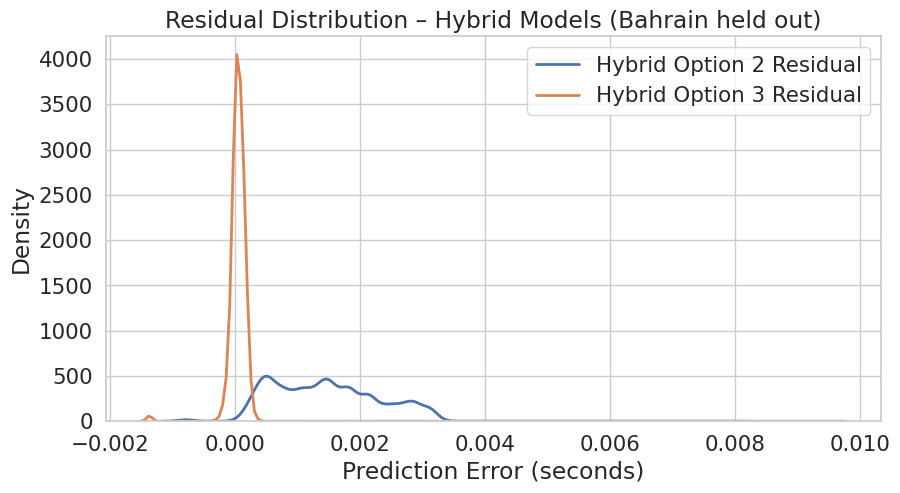

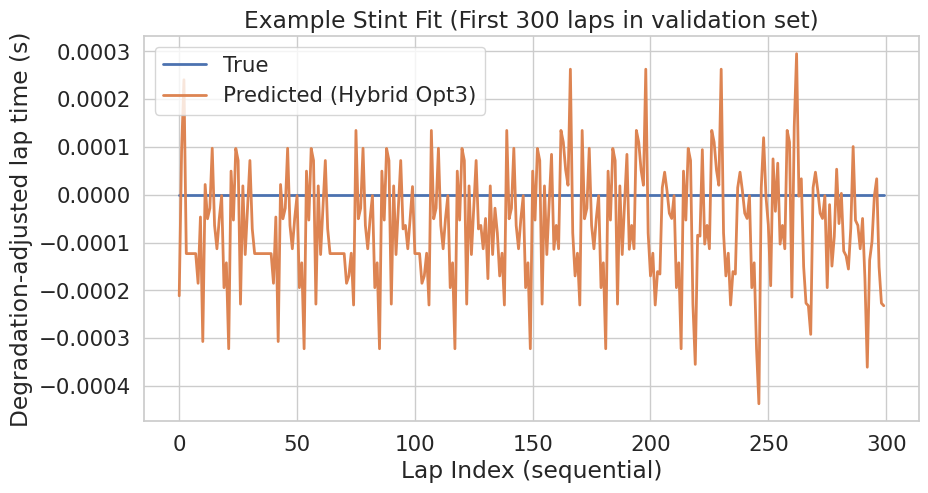

/tmp/ipython-input-2884716353.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=rmse_scores, palette="viridis")


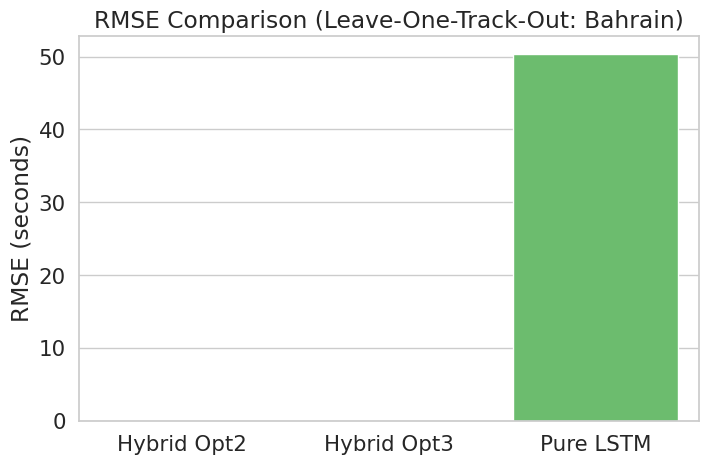

/tmp/ipython-input-2884716353.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mae_scores, palette="magma")


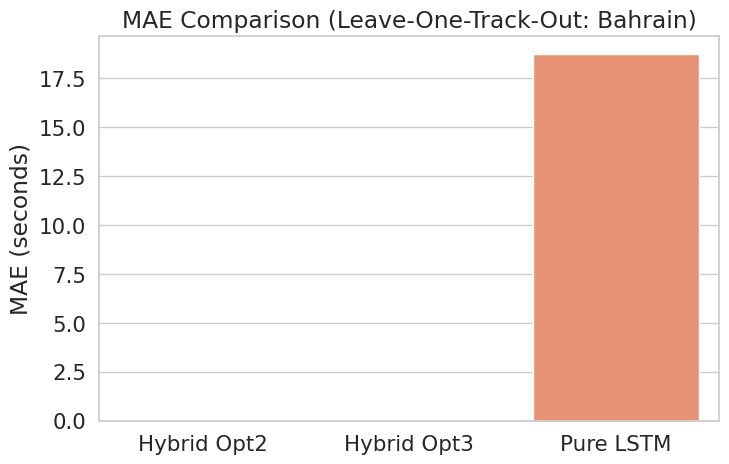

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", font_scale=1.4)

pred_opt2 = metrics_opt2["preds"]
true_opt2 = metrics_opt2["targets"]

pred_opt3 = metrics_opt3["preds"]
true_opt3 = metrics_opt3["targets"]

pred_pure = metrics_pure["preds"]
true_pure = metrics_pure["targets"]

plt.figure(figsize=(10,5))
sns.kdeplot(true_opt2 - pred_opt2, label="Hybrid Option 2 Residual", linewidth=2)
sns.kdeplot(true_opt3 - pred_opt3, label="Hybrid Option 3 Residual", linewidth=2)
plt.title(f"Residual Distribution – Hybrid Models ({VAL_TRACK} held out)")
plt.xlabel("Prediction Error (seconds)")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(true_opt3[:300], label="True", linewidth=2)
plt.plot(pred_opt3[:300], label="Predicted (Hybrid Opt3)", linewidth=2)
plt.title("Example Stint Fit (First 300 laps in validation set)")
plt.ylabel("Degradation-adjusted lap time (s)")
plt.xlabel("Lap Index (sequential)")
plt.legend()
plt.show()

models = ["Hybrid Opt2", "Hybrid Opt3", "Pure LSTM"]
rmse_scores = [metrics_opt2["RMSE"], metrics_opt3["RMSE"], metrics_pure["RMSE"]]
mae_scores = [metrics_opt2["MAE"], metrics_opt3["MAE"], metrics_pure["MAE"]]

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=rmse_scores, palette="viridis")
plt.title(f"RMSE Comparison (Leave-One-Track-Out: {VAL_TRACK})")
plt.ylabel("RMSE (seconds)")
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x=models, y=mae_scores, palette="magma")
plt.title(f"MAE Comparison (Leave-One-Track-Out: {VAL_TRACK})")
plt.ylabel("MAE (seconds)")
plt.show()


In [18]:
import torch
import numpy as np

def simulate_stint(compound, laps, base_lap_time, model, compound_dummies, optional_feats=None, track_env=None):
    window = np.zeros((SEQ_LEN, len(opt3_features)), dtype=np.float32)
    lap_times = []

    for lap in range(1, laps+1):
        feat = []

        if lap_times:
            feat.append(lap_times[-1] - base_lap_time)
        else:
            feat.append(0.0)

        feat.append(lap)

        for c in compound_dummies.columns:
            feat.append(1 if c == f"compound_{compound.upper()}" else 0)

        if track_env:
            for key in optional_feats:
                feat.append(track_env.get(key, 0.0))

        feat = np.array(feat, dtype=np.float32)

        window = np.vstack([window[1:], feat])
        inp = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            deg_pred = model(inp).cpu().numpy()[0]

        lap_time = base_lap_time + deg_pred
        lap_times.append(lap_time)

    return np.array(lap_times)


def simulate_race(strategy, base_lap_time, pit_loss, model, compound_dummies, optional_feats=None, track_env=None):
    total_time = 0.0
    all_laps = []

    for compound, stint_laps in strategy:
        stint_times = simulate_stint(
            compound,
            stint_laps,
            base_lap_time,
            model,
            compound_dummies,
            optional_feats=optional_feats,
            track_env=track_env
        )
        total_time += np.sum(stint_times)
        all_laps.extend(stint_times.tolist())
        total_time += pit_loss

    return total_time, np.array(all_laps)


In [19]:
strategies = {
    "SOFT → MEDIUM → MEDIUM": [("SOFT", 14), ("MEDIUM", 21), ("MEDIUM", 22)],
    "MEDIUM → MEDIUM → HARD": [("MEDIUM", 20), ("MEDIUM", 20), ("HARD", 17)],
    "SOFT → HARD": [("SOFT", 12), ("HARD", 45)]
}

pit_loss = 21.5       # Bahrain average pit delta
base_lap_time = 92.5  # Representative initial pace (adjust if needed)

for name, strat in strategies.items():
    total, laps = simulate_race(
        strat, base_lap_time, pit_loss,
        model_opt3, compound_dummies,
        optional_feats=optional_feats,
        track_env=None  # we can add real temp data later
    )
    print(f"{name:25s}  →  Race Time = {round(total,2)} sec")


SOFT → MEDIUM → MEDIUM     →  Race Time = 5340.85986328125 sec
MEDIUM → MEDIUM → HARD     →  Race Time = 5340.85986328125 sec
SOFT → HARD                →  Race Time = 5317.14990234375 sec


In [20]:
torch.save(model_opt3.state_dict(), "hybrid_opt3_final.pth")

In [21]:
from google.colab import files
files.download("hybrid_opt3_final.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
import json

feature_info = {
    "opt3_features": opt3_features,
    "compound_dummies": list(compound_dummies.columns),
    "optional_feats": optional_feats,
    "seq_len": SEQ_LEN
}

with open("model_features.json", "w") as f:
    json.dump(feature_info, f, indent=4)

from google.colab import files
files.download("model_features.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>